<a href="https://colab.research.google.com/github/chiangtinhung-rgb/Matcha/blob/main/HW5_%E5%B0%8F%E5%90%83%E6%B1%BA%E7%AD%96%E5%99%A8%EF%BC%88%E5%B8%B6%E6%A2%9D%E4%BB%B6%E9%81%8E%E6%BF%BE%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# （作業五）條件式篩選決策器：中山區小吃智慧推薦系統


一、 專案核心目標 (Objective)

本系統旨在解決日常或團體聚會時的「選擇困難症」，

透過智慧化的條件篩選與推薦機制，快速產出符合使用者需求的餐廳候選名單。

二、 程式執行流程與功能亮點

***資料擷取與輸入：***

系統會從指定的 Sheet（試算表） 中讀取完整的餐廳資料清單。


***精確條件過濾 (Conditional Filtering)：***

根據使用者輸入的需求，對餐廳清單進行多重篩選，確保推薦結果的實用性。


*過濾條件包含： 餐廳的價位區間、與當前位置的距離遠近。

***隨機推薦機制：***

從所有符合篩選條件的餐廳中，隨機挑選 20 家作為最終推薦名單。

此機制兼顧了選擇的效率與多樣性。

***建議清單輸出：***

將這 20 家候選餐廳的完整資訊（包含名稱、價位、距離等）

整理成一份結構化的建議清單，供使用者參考。

三、 AI 回饋

為進一步優化使用者的決策速度，本系統整合 AI 智能摘要功能：

功能： 系統會自動分析這 20 家推薦餐廳的關鍵數據和特點。

輸出： 將每家餐廳的核心優點與可能考量的缺點（如 CP 值、地理便利性、菜式特色等）濃縮整合，產出一段約 150 字的精簡摘要說明。


***示範圖片參考***

**決策條件與清單**

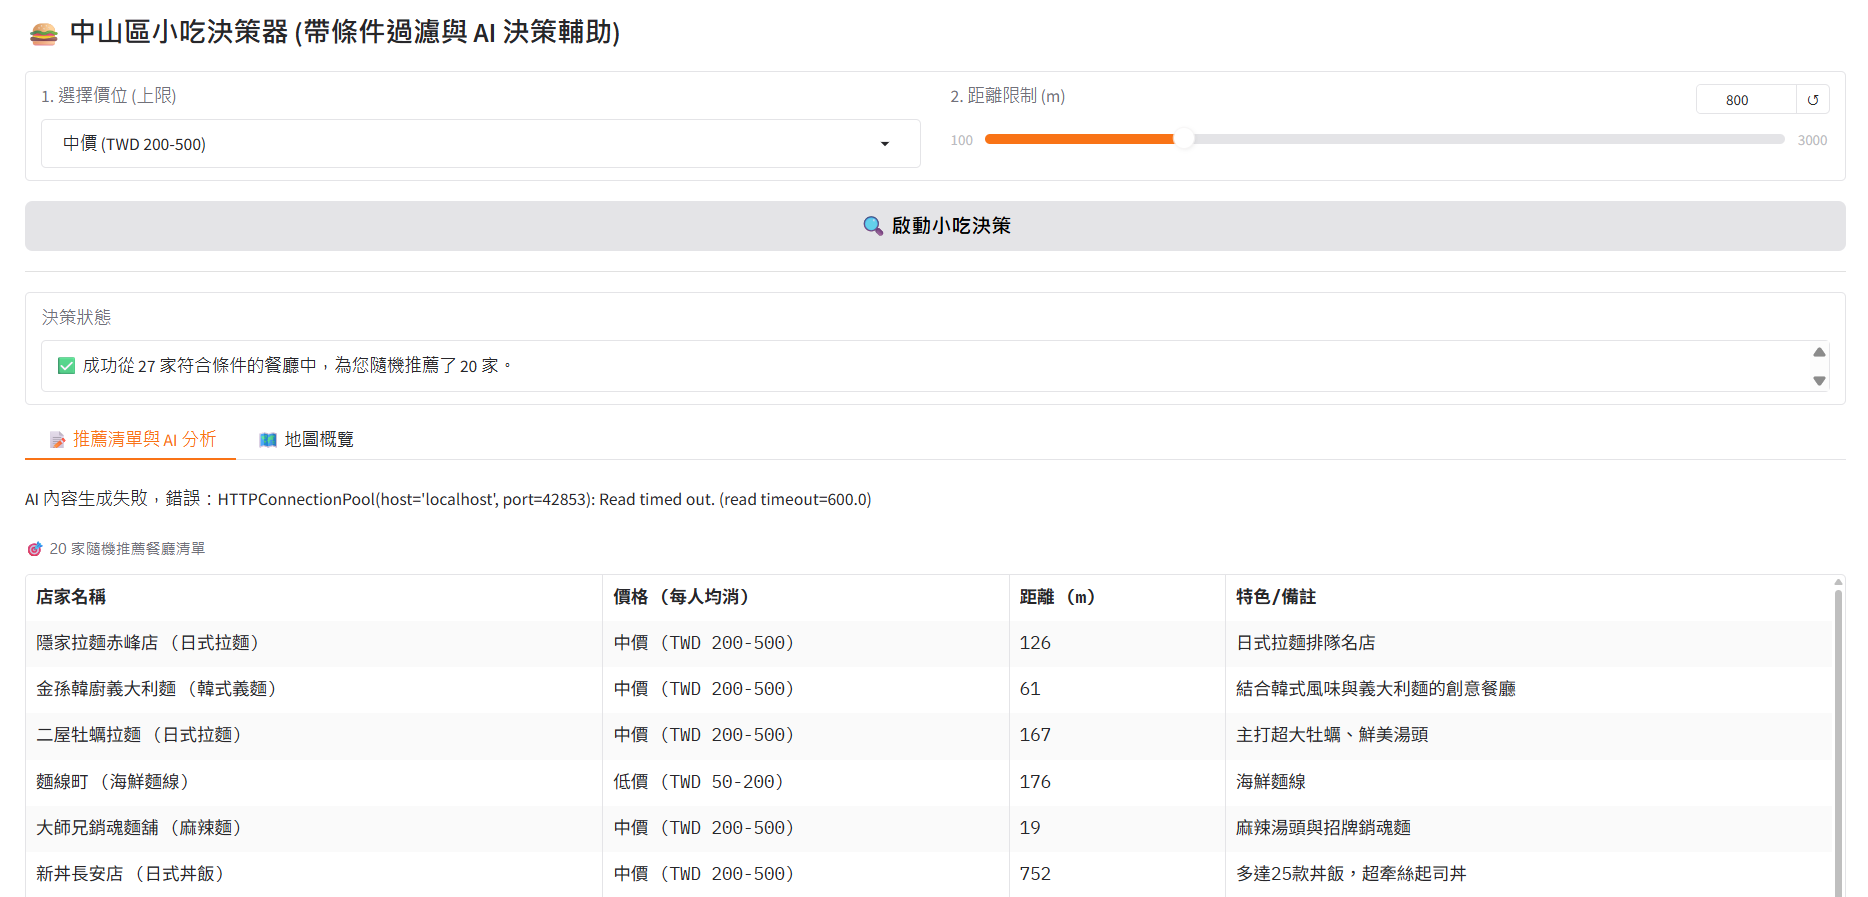

**地圖參考(以中山捷運站為基準點)**

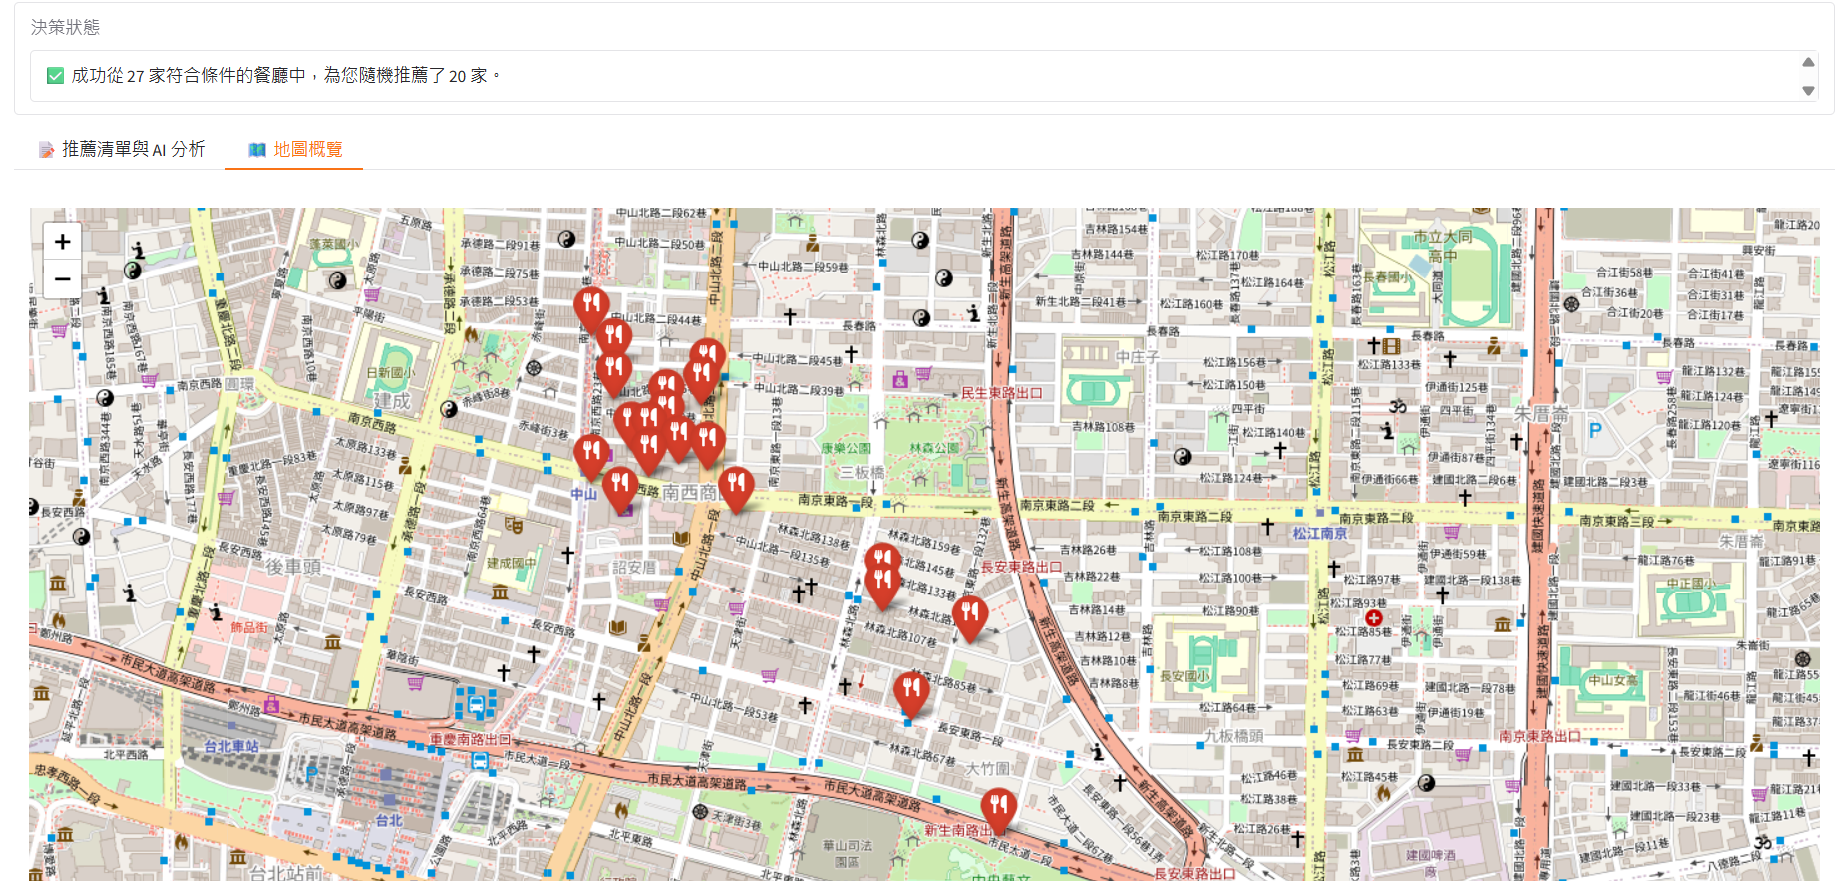

**正式完整程式碼**

In [80]:
!pip install folium

In [81]:
import os, time, uuid, re, json, datetime
from datetime import datetime as dt, timedelta
from dateutil.tz import gettz
import pandas as pd
import gradio as gr
import requests
from bs4 import BeautifulSoup

import google.generativeai as genai

# Google Auth & Sheets
from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.auth import default

In [82]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [83]:
from google.colab import userdata

# 從 Colab Secrets 中獲取 API 金鑰
api_key = userdata.get('MATCHA')

# 使用獲取的金鑰配置 genai
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-pro')

In [98]:
import folium
lat =  25.054898855768
lng = 121.520678010546
m = folium.Map(location=(lat, lng), zoom_start=15)

In [99]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/1Oz0qgvx1OEEJY8M41Z3FOd_8iyoXqtlJwsHP_TUgWpM/edit?usp=sharing"
WORKSHEET_NAME = "工作表1"
TIMEZONE = "Asia/Taipei"

In [100]:
# 從 gsheets 的 All-whiteboard-device 載入 sheets
gsheets = gc.open_by_url(SHEET_URL)
sheets = gsheets.worksheet(WORKSHEET_NAME).get_all_values()

# 將 sheets1 資料載入 pd 的 DataFrame 進行分析
df_restaurants = pd.DataFrame(sheets[1:], columns=sheets[0])

# 使用 .sample(n=20) 隨機抽取 20 行資料
# 這裡繼續使用 random_state=42，確保抽樣結果一致
df_random_restaurants = df_restaurants.sample(n=20, random_state=42)

# --- 顯示所有 20 筆隨機抽取結果的程式碼 ---
print("--- 隨機抽取的 20 家餐廳結果如下 ---")
# 由於您只抽取了 20 筆，直接顯示整個 DataFrame 即可看到全部 20 筆資料
print(df_random_restaurants)
# 或直接在 Notebook/環境的最後一行輸入變數名稱：
# df_random_restaurants

--- 隨機抽取的 20 家餐廳結果如下 ---
    編號                  店家名稱                特色/備註           價格 (每人均消)  \
13  14         二屋牡蠣拉麵 (日式拉麵)          主打超大牡蠣、鮮美湯頭    中價 (TWD 200-500)   
39  40          阿美飯店 (台菜/海鮮)                 台菜老店  中高價 (TWD 500-1000)   
30  31         福大蒸餃館 (蒸餃/抄手)               30年老字號     低價 (TWD 50-200)   
45  46          牛小路壽喜燒 (壽喜燒)                  壽喜燒  中高價 (TWD 500-1000)   
17  18         南山炸豬排 (韓式炸豬排)                韓式炸豬排    中價 (TWD 200-500)   
48  49          富士山の豬 (日式餐飲)             日式居酒屋/餐飲  中高價 (TWD 500-1000)   
26  27  Tart club 蛋塔俱樂部 (甜點)              人氣可愛蛋塔店     低價 (TWD 50-200)   
25  26          躺平綠豆沙牛奶 (飲品)           細緻綿密的綠豆沙牛奶     低價 (TWD 50-200)   
32  33           肥前屋 (日式鰻魚飯)            平價鰻魚飯排隊名店    中價 (TWD 200-500)   
19  20          龍都酒樓 (粵菜/烤鴨)            台北老字號烤鴨名店  中高價 (TWD 500-1000)   
12  13        隱家拉麵赤峰店 (日式拉麵)             日式拉麵排隊名店    中價 (TWD 200-500)   
4    5          赤峰街排骨飯 (排骨飯)                傳統排骨飯     低價 (TWD 50-200)   
37  38         福州世祖胡椒餅 (胡椒

In [101]:
for i in range(0, len(df_restaurants)):
  lat = df_restaurants['lat'][i]
  lng = df_restaurants['lng'][i]
  tooltip_str = df_restaurants['店家名稱'][i]
  popup_str = df_restaurants['特色/備註'][i]

  folium.Marker(
      location = [lat, lng],
      tooltip = tooltip_str,
      popup = popup_str,
      icon=folium.Icon(icon="cloud"),
  ).add_to(m)

In [102]:
m

In [105]:
# gsheets = gc.open_by_url(SHEET_URL)
# sheets = gsheets.worksheet(WORKSHEET_NAME).get_all_values()
# df_restaurants = pd.DataFrame(sheets[1:], columns=sheets[0])

# --- 新增數據清理與轉換 ---
df_restaurants = df_restaurants.copy()

# 轉換 lat, lng 為浮點數 (float)
df_restaurants['lat'] = pd.to_numeric(df_restaurants['lat'], errors='coerce')
df_restaurants['lng'] = pd.to_numeric(df_restaurants['lng'], errors='coerce')

# 轉換 distance 為整數 (int)
df_restaurants['distance'] = pd.to_numeric(df_restaurants['distance'], errors='coerce').fillna(9999).astype(int)

# 移除無效的地理資訊
df_restaurants.dropna(subset=['lat', 'lng'], inplace=True)
df_restaurants.reset_index(drop=True, inplace=True)

# 定義價格區間的排序
price_order = {
    '低價 (TWD 50-200)': 1,
    '中價 (TWD 200-500)': 2,
    '中高價 (TWD 500-1000)': 3,
    '高價 (TWD 1000+)': 4
}
df_restaurants['Price_Rank'] = df_restaurants['價格 (每人均消)'].map(price_order)

In [111]:
# 將地圖物件轉為 HTML 供 Gradio 顯示

def map_to_html(map_obj):
    if map_obj is None:
        return "沒有地圖可顯示。"
    # 💡 使用 _repr_html_() 方法將 Folium 地圖物件轉為 HTML 字符串
    return map_obj._repr_html_()

In [112]:
import pandas as pd
import folium
import gradio as gr
# 假設您已在前面執行了 genai.configure(api_key=api_key) 和 model = genai.GenerativeModel('gemini-2.5-pro')

def generate_summary(df_selected_restaurants):
    """使用 Gemini-2.5-Pro 生成 150 字的優缺點說明及建議清單。"""

    # 建立餐廳清單字串
    restaurant_list = ""
    for index, row in df_selected_restaurants.iterrows():
        restaurant_list += f"- {row['店家名稱']} ({row['價格 (每人均消)']}，特色：{row['特色/備註']}，距離：{row['distance']}m)\n"

    prompt = f"""
    您是一位美食決策分析師。根據以下中山區小吃店名單，請完成以下任務：
    1. 生成一份長度約 150 字的綜合說明，內容需包含：
       - 快速決策建議（例如：此名單包含低價美食和高級聚餐選項）。
       - 簡要分析這 20 家店的優點和缺點（例如：優點：價格區間多樣、日式料理豐富；缺點：部分店家距離較遠、需排隊）。
    2. 生成一個「各類建議清單」，例如：
       - 最適合「省錢」的 Top 3
       - 最適合「上班族」的店家
       - 最適合「團體聚餐」的 Top 3

    餐廳名單：
    {restaurant_list}
    """

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"AI 內容生成失敗，錯誤：{e}"


def generate_map_html(df_selected_restaurants):
    """生成包含 20 家推薦餐廳標記的 Folium 地圖 HTML 內容。"""

    # 以所有餐廳的平均經緯度為中心點，或使用中山區預設中心點
    if not df_selected_restaurants.empty:
        center_lat = df_selected_restaurants['lat'].mean()
        center_lng = df_selected_restaurants['lng'].mean()
    else:
        # 預設中山區中心點
        center_lat = 25.054898855768
        center_lng = 121.520678010546

    m = folium.Map(location=(center_lat, center_lng), zoom_start=15)

    for index, row in df_selected_restaurants.iterrows():
        lat = row['lat']
        lng = row['lng']
        tooltip_str = row['店家名稱']
        popup_str = f"**{row['店家名稱']}**<br>價格: {row['價格 (每人均消)']}<br>距離: {row['distance']}m<br>特色: {row['特色/備註']}"

        folium.Marker(
            location=[lat, lng],
            tooltip=tooltip_str,
            popup=popup_str,
            icon=folium.Icon(color="red", icon="cutlery", prefix='fa')
        ).add_to(m)

    # 將 Folium 地圖物件轉換為 HTML 字符串
    map_html = m._repr_html_()
    return map_html

def recommend_snacks(price_filter, distance_filter):
    """整合篩選、隨機推薦、AI 總結和地圖生成的主函式。"""

    # 1. 條件篩選
    # 根據用戶選擇的價格等級進行篩選 (例如：選「低價」會包含所有「低價」的店)
    if price_filter != '不限':
        filter_rank = price_order[price_filter]
        df_filtered = df_restaurants[df_restaurants['Price_Rank'] <= filter_rank].copy()
    else:
        df_filtered = df_restaurants.copy()

    # 根據用戶選擇的距離進行篩選
    df_filtered = df_filtered[df_filtered['distance'] <= distance_filter]

    if df_filtered.empty:
        return (
            "⚠️ 抱歉，沒有餐廳符合您設定的價位和距離條件。",
            "**請調整您的篩選條件。**",
            "<div><p>無結果顯示地圖。</p></div>",
            pd.DataFrame({'店家名稱': [], '價格 (每人均消)': [], '距離': [], '特色/備註': []})
        )

    # 2. 隨機推薦 20 家 (如果總數不足 20，則全部推薦)
    n_recommend = min(20, len(df_filtered))
    df_recommended = df_filtered.sample(n=n_recommend, random_state=42) # 使用固定 random_state 確保結果可重現

    # 3. 整理輸出清單
    output_df = df_recommended[['店家名稱', '價格 (每人均消)', 'distance', '特色/備註']].copy()
    output_df.rename(columns={'distance': '距離 (m)'}, inplace=True)

    # 4. 生成 AI 內容
    ai_output = generate_summary(df_recommended)

    # 5. 生成地圖
    map_html = generate_map_html(df_recommended)

    # 6. 組合結果 (Gradio 需要多個回傳值)
    return (
        f"✅ 成功從 {len(df_filtered)} 家符合條件的餐廳中，為您隨機推薦了 {n_recommend} 家。",
        ai_output,
        map_html,
        output_df
    )

In [114]:
# --- Gradio 介面統整 ---
price_choices = ['不限', '低價 (TWD 50-200)', '中價 (TWD 200-500)', '中高價 (TWD 500-1000)', '高價 (TWD 1000+)']

with gr.Blocks(title="中山區小吃決策器") as demo:
    gr.Markdown("## 🍔 中山區小吃決策器 (帶條件過濾與 AI 決策輔助)")

    with gr.Row():
        price_input = gr.Dropdown(
            choices=price_choices,
            label="1. 選擇價位 (上限)",
            value="不限",
            interactive=True
        )
        distance_input = gr.Slider(
            minimum=100,
            maximum=3000,
            value=500,
            step=100,
            label="2. 距離限制 (m)",
            interactive=True
        )

    recommend_button = gr.Button("🔍 啟動小吃決策")

    gr.Markdown("---")

    # 輸出元件
    status_output = gr.Textbox(label="決策狀態", interactive=False)

    with gr.Tab("📝 推薦清單與 AI 分析"):
        # ⚠️ 修正：移除 gr.Markdown 的 interactive=False 參數
        ai_summary_output = gr.Markdown("### 🤖 AI 綜合分析與建議清單 (約 150 字)")

        table_output = gr.Dataframe(label="🎯 20 家隨機推薦餐廳清單",
                                    headers=['店家名稱', '價格 (每人均消)', '距離 (m)', '特色/備註'],
                                    interactive=False)

    with gr.Tab("🗺️ 地圖概覽"):
        map_output = gr.HTML(label="地圖顯示", elem_id="map-container")

    # 連結按鈕和主函式
    recommend_button.click(
        fn=recommend_snacks,
        inputs=[price_input, distance_input],
        outputs=[status_output, ai_summary_output, map_output, table_output]
    )


if __name__ == "__main__":
    demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1129d885eb5502eb1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
